In [68]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

colour_pal = sns.color_palette()
plt.style.use('ggplot')

# Load DataSet

In [9]:
dfE = pd.read_csv('DataSet/Regions/PJME_hourly.csv').set_index('Datetime')
dfE.index = pd.to_datetime(dfE.index)
dfE

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [10]:
dfE.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [11]:
dfW = pd.read_csv('DataSet/Regions/PJMW_hourly.csv').set_index('Datetime')
dfW.index = pd.to_datetime(dfW.index)
dfW

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0
...,...
2018-01-01 20:00:00,8401.0
2018-01-01 21:00:00,8373.0
2018-01-01 22:00:00,8238.0


In [12]:
dfW.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


In [13]:
dfW.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


### Concat both data frames

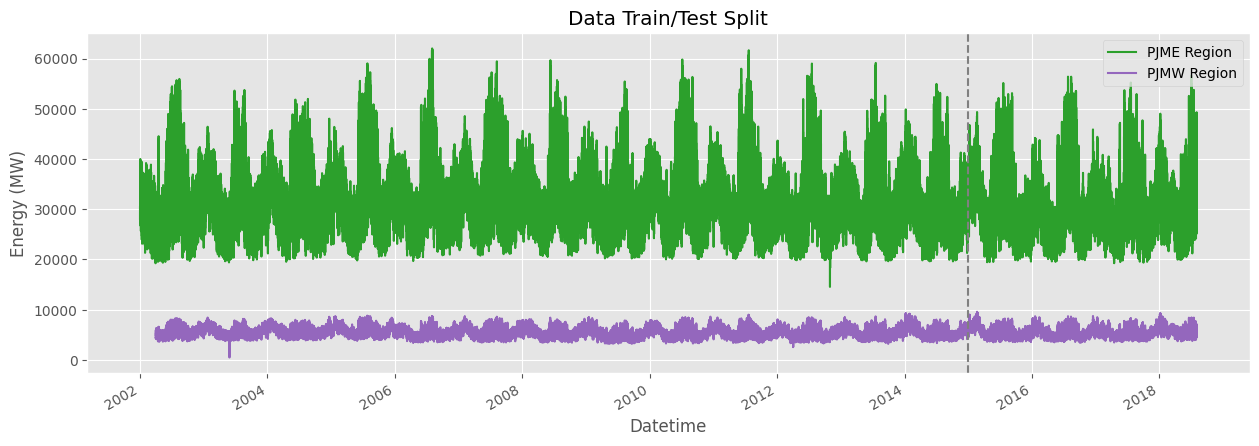

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
dfE.plot(ax=ax, label='Training Set',
           color=colour_pal[2], title='Data Train/Test Split')
dfW.plot(ax=ax, label='Test Set', color=colour_pal[4])
ax.axvline('01-01-2015', color='grey', ls='--')
ax.legend(['PJME Region', 'PJMW Region'])
ax.set_ylabel('Energy (MW)')
plt.show()

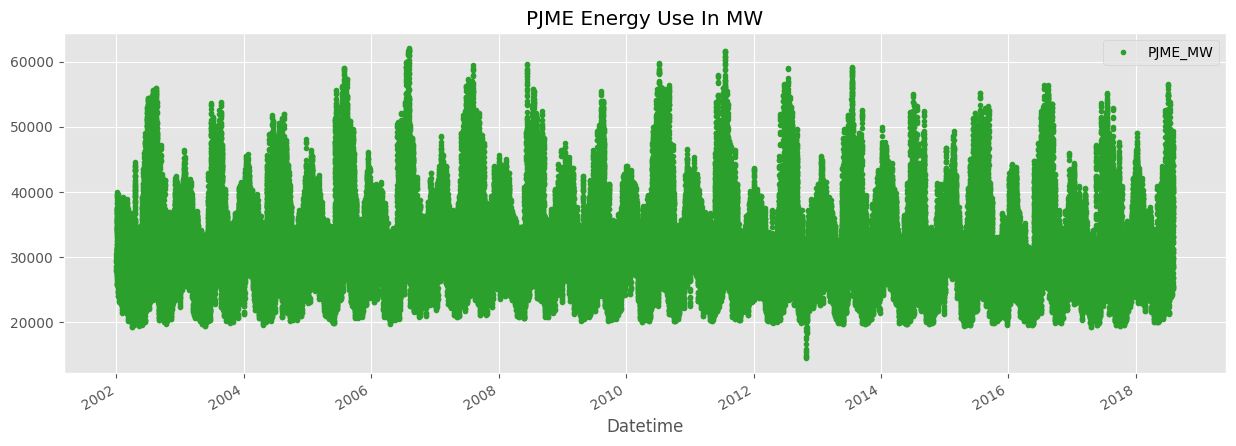

In [15]:
dfE.plot(style='.', 
        figsize=(15,5), 
        color=colour_pal[2], 
        title='PJME Energy Use In MW')
plt.show()

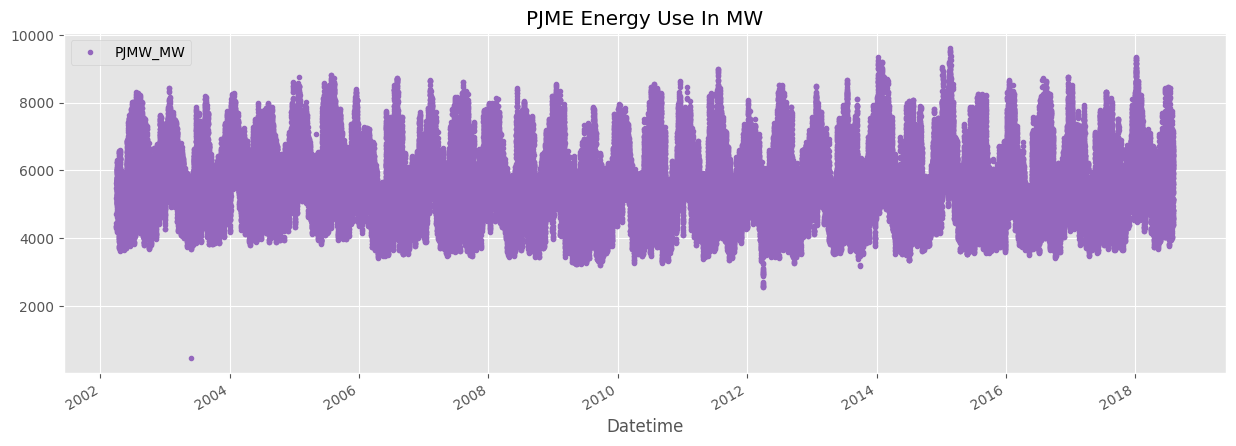

In [16]:
dfW.plot(style='.',
         figsize=(15, 5),
         color=colour_pal[4],
         title='PJME Energy Use In MW')
plt.show()

## Outlier Analysis and Removal (Cleaning)
- week in 2010 where there were consistent brown outs, creating outliers

<Axes: ylabel='Frequency'>

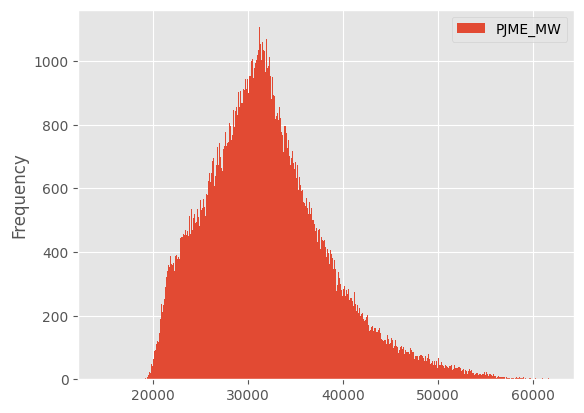

In [18]:
dfE.plot(kind='hist', bins=500)

<Axes: ylabel='Frequency'>

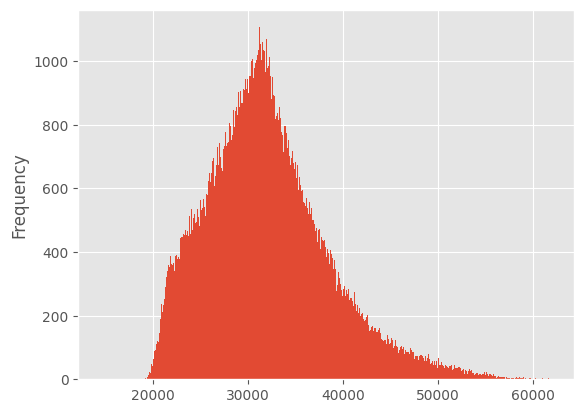

In [ ]:
dfE['PJME_MW'].plot(kind='hist', bins=500)

<Axes: ylabel='Frequency'>

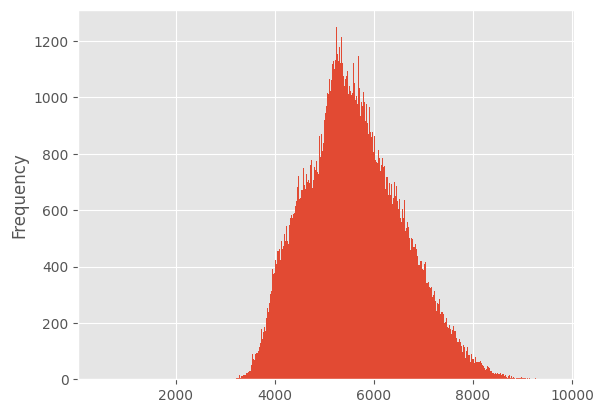

In [ ]:
dfW['PJMW_MW'].plot(kind='hist', bins=500)

<Axes: xlabel='Datetime'>

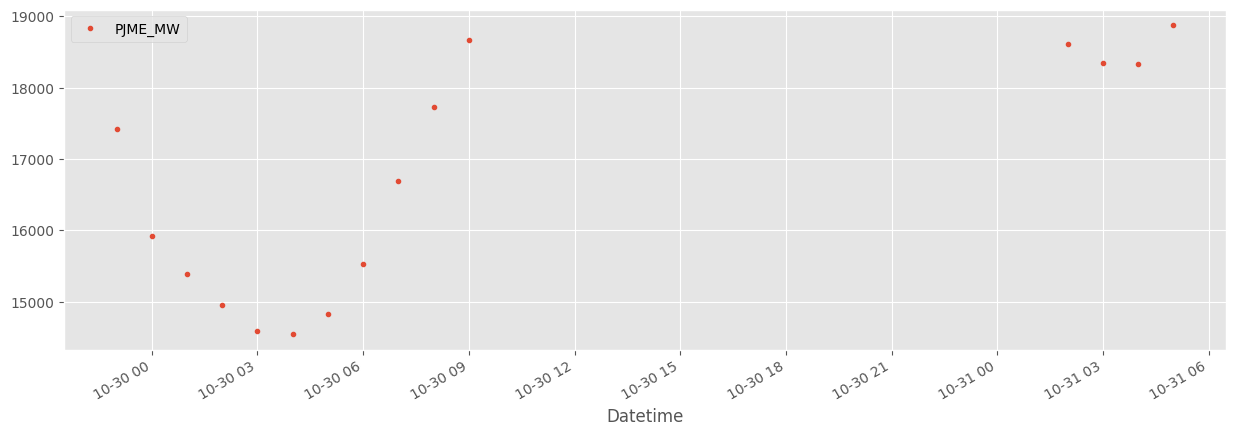

In [ ]:
dfE.query('PJME_MW < 19_000').plot(figsize=(15,5), style='.')

- could also look at stdn and number of outliers to analyse quantitatively

In [19]:
df = dfE.query('PJME_MW > 19_000').copy()

#### Correlation Analysis
- environmental factors
- holidays
- employment vs unemployment
- density of people / number of people in a house hold
- types of energy productions
- use heat maps and scaller plots to determine the correlatins and if relevant

# Train/Test Split
- will split train and test on Jan 01  (80:20 split)
- using Single Linear Regression

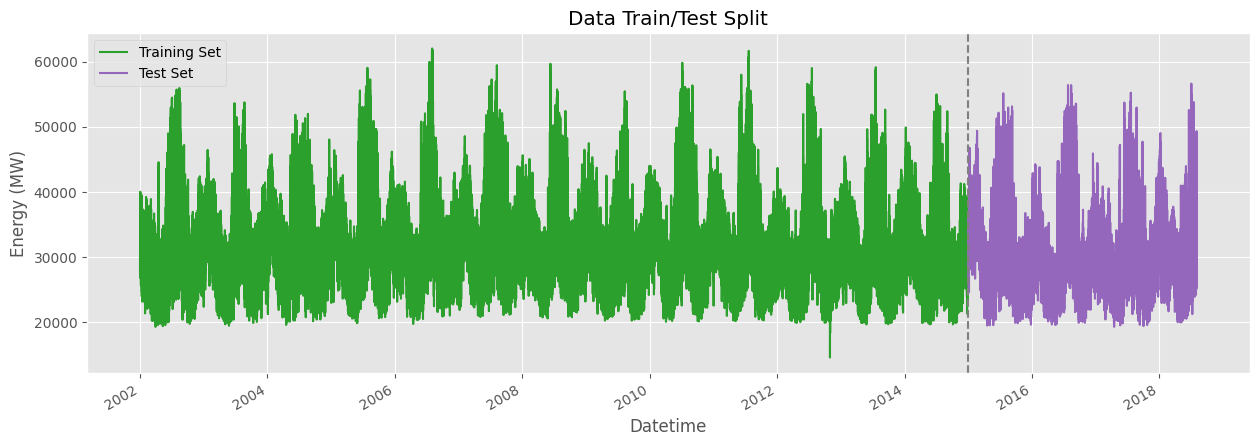

In [20]:
train = dfE.loc[dfE.index < '01-01-2015']
test = dfE.loc[dfE.index > '01-01-2015']

fig, ax =plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', color=colour_pal[2], title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set', color=colour_pal[4])
ax.axvline('01-01-2015', color='grey', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Energy (MW)')
plt.show()

Weekly Trends

<Axes: xlabel='Datetime'>

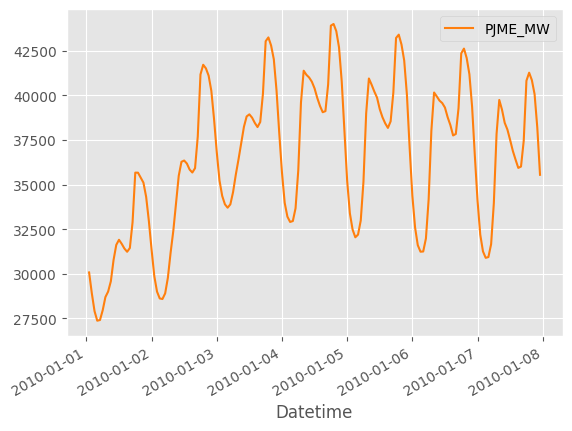

In [21]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(color=colour_pal[1])

# Time Series Cross Validation
- another method of spliting data sets for predicting into the future

In [77]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

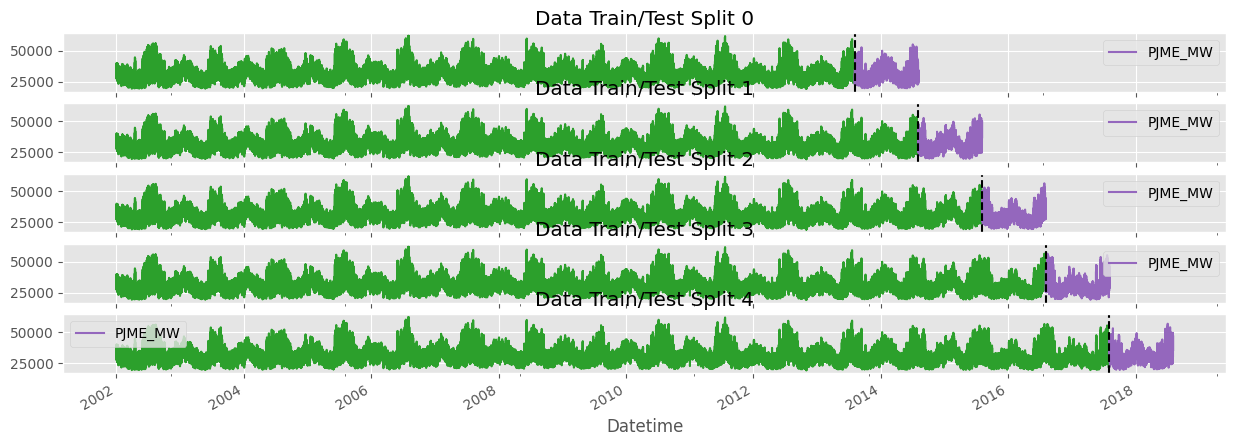

In [23]:
fig, ax = plt.subplots(5, 1, figsize=(15,5), sharex=True)
fold=0

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    train['PJME_MW'].plot(ax=ax[fold], label='Training Set', color=colour_pal[2], title=f'Data Train/Test Split {fold}')
    test.plot(ax=ax[fold], label='Test Set', color=colour_pal[4])
    ax[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1


# Create Features
- the length of time into the future for which forcasts are prepared

# Lag Features
- What was the target (x) days in the past

In [26]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag_1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag_3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)    

    return df

In [27]:
df = add_lags(df)
df.tail()

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,lag_1,lag_2,lag_3
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,33539.0,32094.0,31695.0


## Visualize Feature/ Target Relationships

Per Hour

/var/folders/8j/09rp00zx1ydb5ybglm3nyhgh0000gn/T/ipykernel_97172/3697910360.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Greens')


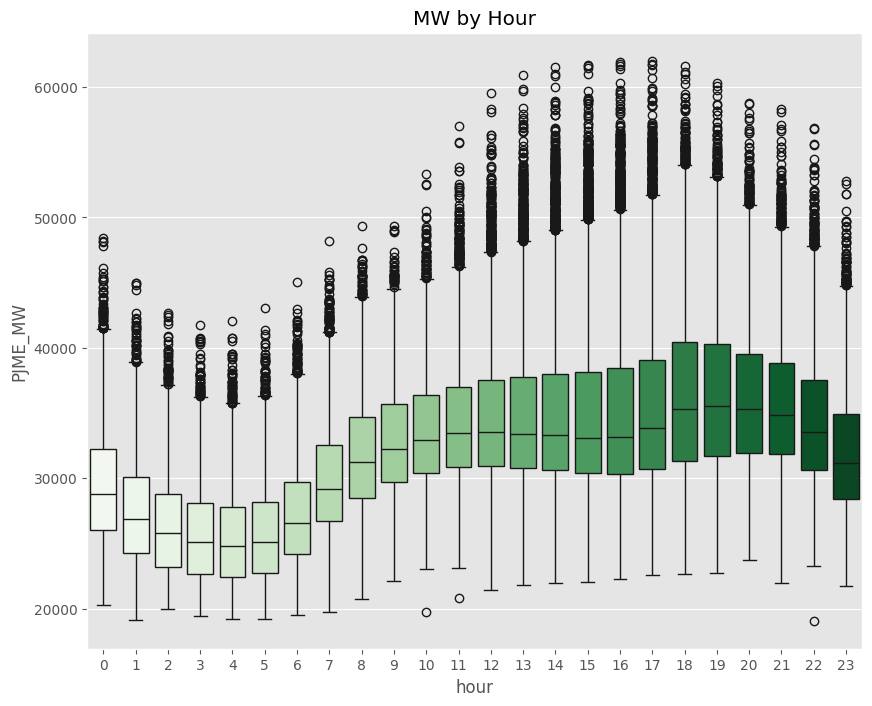

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Greens')
ax.set_title('MW by Hour')
plt.show()

Per Month

/var/folders/8j/09rp00zx1ydb5ybglm3nyhgh0000gn/T/ipykernel_97172/2202713226.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


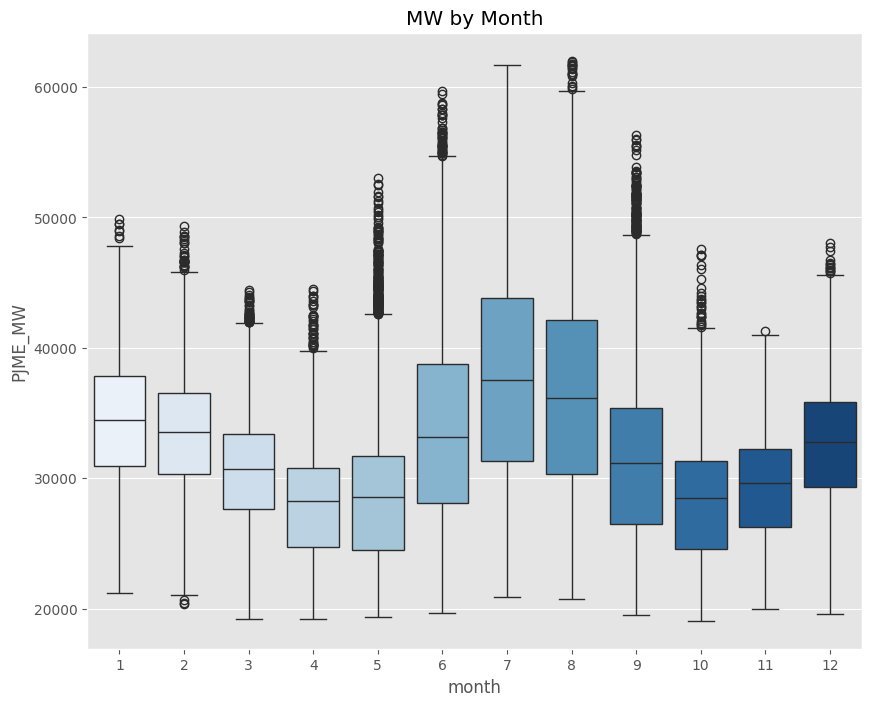

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

Per Year

/var/folders/8j/09rp00zx1ydb5ybglm3nyhgh0000gn/T/ipykernel_97172/732862665.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='year', y='PJME_MW', palette='Blues')


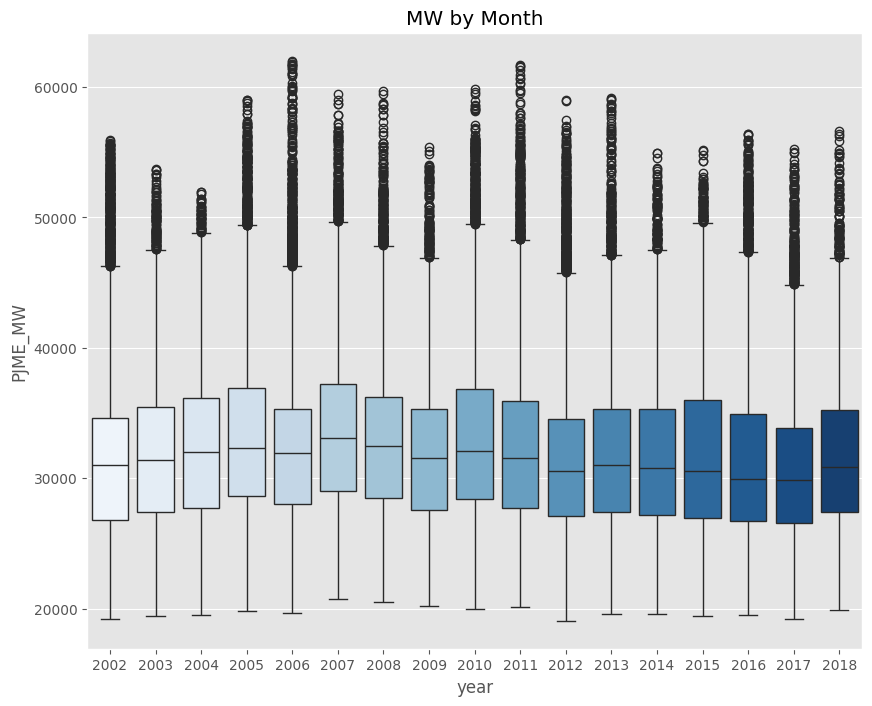

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create Model

In [59]:
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['year'] = df.index.year

    return df

In [60]:
df = create_features(df)

In [31]:
train = create_features(train)
test = create_features(test)

In [57]:
FEATURES = ['hour', 'month', 'year']
TARGET = 'PJME_MW'

In [58]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

## No Cross Validation
- not the best model as it is not considering time series and seasonality

In [62]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [63]:
y_pred = lm.predict(x_test)


In [64]:
result = pd.DataFrame({
    'Actual': y_test,
    'Predict': y_pred
})
result['Diff'] = y_test - y_pred
result

,Actual,Predict,Diff
Datetime,,,
2017-08-03 03:00:00,26544.0,27535.296215,-991.296215
2017-08-03 04:00:00,26012.0,27992.239501,-1980.239501
2017-08-03 05:00:00,26187.0,28449.182786,-2262.182786
2017-08-03 06:00:00,27504.0,28906.126072,-1402.126072
2017-08-03 07:00:00,29412.0,29363.069357,48.930643
...,...,...,...
2018-08-02 20:00:00,44057.0,35227.230836,8829.769164
2018-08-02 21:00:00,43256.0,35684.174122,7571.825878
2018-08-02 22:00:00,41552.0,36141.117408,5410.882592


In [65]:
print('Estimate INtercept is', lm.intercept_)
print("The Number of coefficients in this model are", lm.coef_)

Estimate INtercept is 180329.48311643398
The Number of coefficients in this model are [456.94328565 -83.60336231 -76.10123444]


Using XGBRegressor

In [66]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg = reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6441.74106	validation_1-rmse:6095.65110


[100]	validation_0-rmse:4274.97740	validation_1-rmse:4329.48116
[200]	validation_0-rmse:3794.08464	validation_1-rmse:4058.44425
[300]	validation_0-rmse:3659.58766	validation_1-rmse:4025.67670
[327]	validation_0-rmse:3634.27295	validation_1-rmse:4026.04242


# Feature Importance

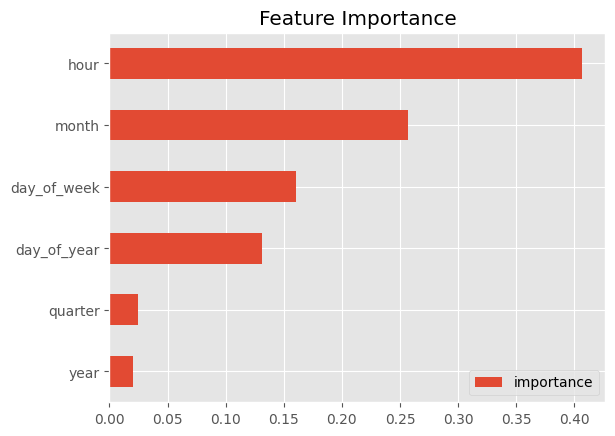

In [35]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forcast on Test Set

In [36]:
test['prediction'] = reg.predict(x_test)
df= df.merge(test[['prediction']], 
             how='left',
             left_index=True,
             right_index=True)
df

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,lag_1,lag_2,lag_3,prediction
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0,43147.937500
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0,42725.914062
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0,41046.945312


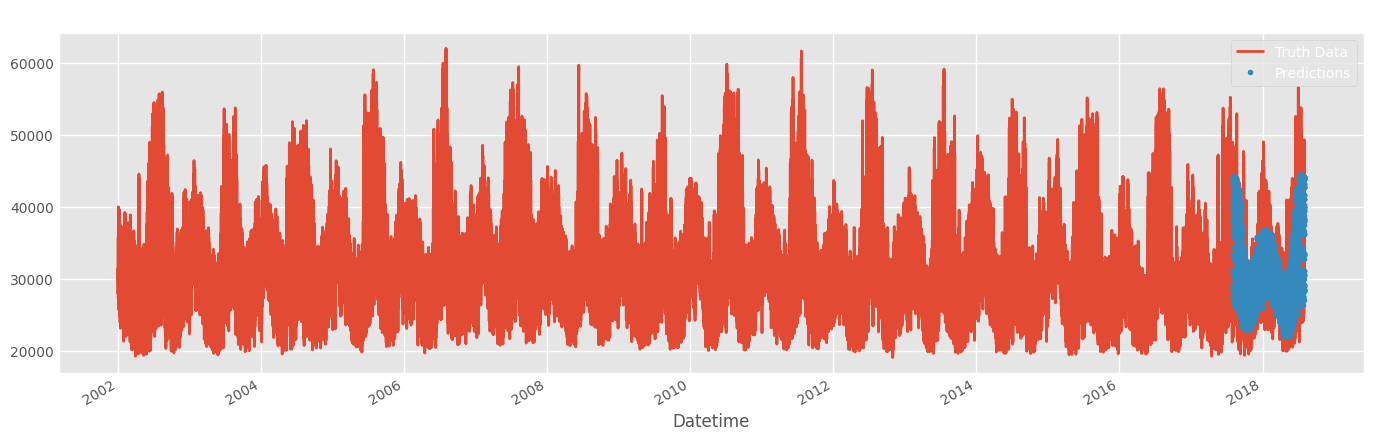

In [ ]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data')
plt.show()

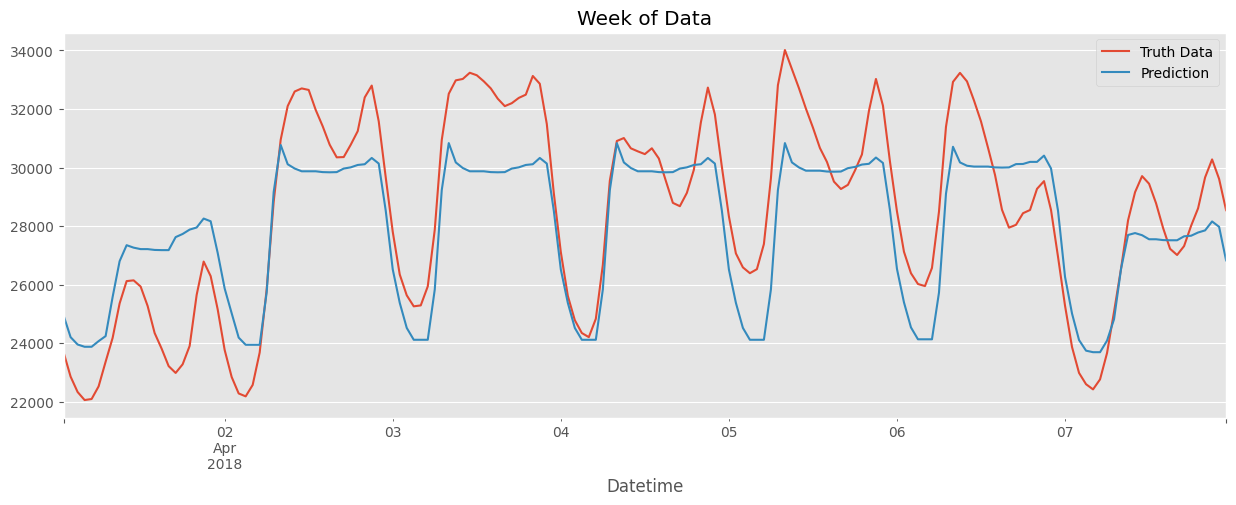

In [37]:
ax = df.loc[(df.index > '04-01-2018')& (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15,5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(figsize=(15, 5), title='Week of Data')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

# Evaluation Metric
- use sqrt of the mean squared error because it makes it the same metric as used by the model

In [38]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3828.93


## Calculate Error
- gives general error for each target vs test
- then look at the worst and best predicted data

In [39]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [40]:
test['date'] = test.index.date

Worst predicted days

In [41]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2018-01-06    11529.277588
2018-01-05    10834.833659
2018-01-07    10675.098877
2017-12-31     9760.117269
2018-01-02     9519.318034
Name: error, dtype: float64

Best Predicted days

In [42]:
test.groupby('date')['error'].mean().sort_values().head(5)

date
2018-05-22    412.137614
2017-09-14    580.284505
2018-05-16    635.412516
2017-11-08    656.319499
2017-11-09    662.803223
Name: error, dtype: float64

## Train Using Cross Validation

In [78]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    FEATURES = ['lag_1','lag_2','lag_3','hour', 'month', 'year']
    TARGET = 'PJME_MW'

    x_train= train[FEATURES]
    y_train =train[TARGET]

    x_test= test[FEATURES]
    y_test =test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        n_estimators=1000, 
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3, 
        learning_rate=0.01)
    reg = reg.fit(x_train, y_train,
              eval_set=[(x_train, y_train), (x_test, y_test)],
              verbose=100)
    
    y_pred = reg.predict(x_test)
    preds.append(y_pred)
    scores.append(score)
    
    

[0]	validation_0-rmse:32732.50831	validation_1-rmse:31955.92056
[100]	validation_0-rmse:12534.86517	validation_1-rmse:11912.60098
[200]	validation_0-rmse:5768.68175	validation_1-rmse:5390.51195
[300]	validation_0-rmse:3928.21654	validation_1-rmse:3966.70308
[400]	validation_0-rmse:3517.23206	validation_1-rmse:3826.22976
[487]	validation_0-rmse:3416.27784	validation_1-rmse:3830.28633
[0]	validation_0-rmse:32672.05400	validation_1-rmse:32140.26642
[100]	validation_0-rmse:12515.68396	validation_1-rmse:12225.09962
[200]	validation_0-rmse:5769.03494	validation_1-rmse:5668.56176
[300]	validation_0-rmse:3958.49253	validation_1-rmse:3957.67099
[400]	validation_0-rmse:3546.73330	validation_1-rmse:3640.95506
[500]	validation_0-rmse:3442.43162	validation_1-rmse:3555.86358
[600]	validation_0-rmse:3397.14975	validation_1-rmse:3506.78392
[700]	validation_0-rmse:3361.34454	validation_1-rmse:3478.39748
[800]	validation_0-rmse:3331.99099	validation_1-rmse:3464.66767
[900]	validation_0-rmse:3311.08300	v

In [76]:
print(f'Scores across folds {np.mean(scores)}')
print(f'Accuracy scores: {scores}')

Scores across folds 3828.9303834748434
Accuracy scores: [3828.9303834748434, 3828.9303834748434, 3828.9303834748434, 3828.9303834748434, 3828.9303834748434]


## Predicting the Future
- estimate up to 500 in this case due to the fact that beyond this the model begins to overfit

In [46]:
df = create_features(df)


FEATURES = ['lag_1','lag_2','lag_3','hour', 'day_of_week', 'quarter', 'month', 'year','day_of_year']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(
        base_score=0.5,
        n_estimators=1000, 
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=3, 
        learning_rate=0.01)
reg.fit(X_all, y_all,
              eval_set=[(X_all, y_all)],
              verbose=100)

[0]	validation_0-rmse:32403.75827


/Users/sjo/miniforge3/envs/playground/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:45:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.71698
[200]	validation_0-rmse:5752.88242
[300]	validation_0-rmse:3971.39460
[400]	validation_0-rmse:3571.32465
[500]	validation_0-rmse:3455.94973
[600]	validation_0-rmse:3401.63260
[700]	validation_0-rmse:3365.81543
[800]	validation_0-rmse:3333.30810
[900]	validation_0-rmse:3308.31510
[999]	validation_0-rmse:3286.44088


XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [47]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [48]:
future = pd.date_range('2018-08-03', '2019-08-03', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [49]:
future_w_features = df_and_future.query('isFuture').copy()

In [50]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

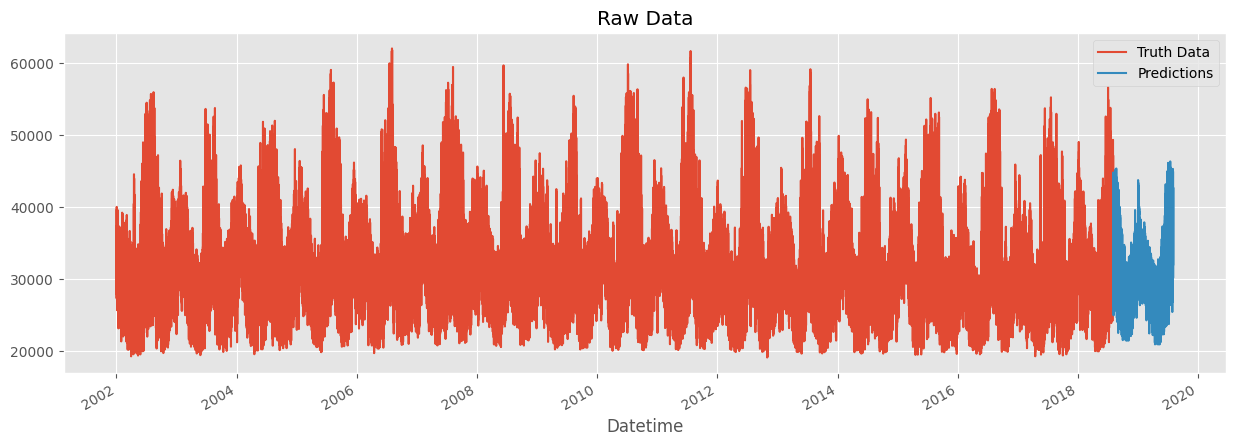

In [56]:

ax = df[['PJME_MW']].plot(figsize=(15, 5))
future_w_features['pred'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data')
plt.show()

# Saving Model for Later

In [54]:
reg.save_model('model.json')

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')